# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [ ]:
library(tidyverse, warn.conflicts=FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'jsonlite'

The following object is masked from 'package:purrr':

    flatten

I want to use `theme_minimal()` by default:

In [ ]:
theme_set(theme_minimal())

And default image sizes aren’t great:

In [ ]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of
the integration. Let’s load those:

In [ ]:
link_stats = read_csv("book-links/gender-stats.csv")

Rows: 32 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, gender
dbl (2): n_books, n_actions

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 32
Columns: 4
$ dataset   <chr> "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-…
$ gender    <chr> "unknown", "no-book-author", "male", "no-author-rec", "ambig…
$ n_books   <dbl> 1081045, 597765, 2427301, 304940, 75499, 744381, 240501, 249…
$ n_actions <dbl> NA, NA, NA, NA, NA, NA, 2184325, 4929576, 2322219, 1117350, …

Now let’s define variables for our variou codes. We are first going to
define our gender codes. We’ll start with the resolved codes:

In [ ]:
link_codes = c('female', 'male', 'ambiguous', 'unknown')

We want the unlink codes in order, so the last is the first link
failure:

In [ ]:
unlink_codes = c('no-author-rec', 'no-book-author', 'no-book')

In [ ]:
all_codes = c(link_codes, unlink_codes)

## Processing Statistics

Now we’ll pivot each of our count columns into a table for easier
reference.

In [ ]:
book_counts = link_stats %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_books) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(book_counts)

Rows: 5
Columns: 9
$ dataset          <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ unknown          <dbl> 1081045, 240501, 305111, 111107, 109227
$ `no-book-author` <dbl> 597765, 166729, 151322, 744727, 732999
$ male             <dbl> 2427301, 552539, 672445, 339839, 335533
$ `no-author-rec`  <dbl> 304940, 157350, 243706, 62274, 61169
$ ambiguous        <dbl> 75499, 24734, 28843, 19554, 19358
$ female           <dbl> 744381, 249726, 317652, 227723, 225418
$ `no-book`        <dbl> 0, 865304, 1134492, 0, 0
$ total            <dbl> 5230931, 2256883, 2853571, 1505224, 1483704

In [ ]:
act_counts = link_stats %>%
    filter(dataset != "LOC-MDS") %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_actions) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(act_counts)

Rows: 4
Columns: 9
$ dataset          <chr> "AZ14", "AZ18", "GR-I", "GR-E"
$ unknown          <dbl> 2184325, 4893185, 10672089, 3691489
$ female           <dbl> 4929576, 12189274, 81254208, 35280395
$ `no-book-author` <dbl> 2322219, 2741320, 29430658, 11066998
$ `no-author-rec`  <dbl> 1117350, 3348368, 3523817, 1025036
$ male             <dbl> 7103317, 15571511, 69576647, 32955525
$ ambiguous        <dbl> 929418, 2054591, 24062454, 14567169
$ `no-book`        <dbl> 3840385, 9857003, 0, 0
$ total            <dbl> 22426590, 50655252, 218519873, 98586612

We’re going to want to compute versions of this table as fractions,
e.g. the fraction of books that are written by women. We will use the
following helper function:

In [ ]:
fractionalize = function(data, columns, unlinked=NULL) {
    fracs = select(data, dataset | all_of(columns))
    if (!is.null(unlinked)) {
        fracs = mutate(fracs, unlinked=rowSums(select(data, all_of(unlinked))))
    }
    totals = rowSums(select(fracs, !dataset))
    fracs %>% mutate(across(!dataset, ~ .x / totals))
}
fractionalize(book_counts, link_codes) %>% glimpse()

Rows: 5
Columns: 5
$ dataset   <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ female    <dbl> 0.1719829, 0.2339354, 0.2399092, 0.3261465, 0.3269126
$ male      <dbl> 0.5608074, 0.5176009, 0.5078694, 0.4867199, 0.4866069
$ ambiguous <dbl> 0.01744341, 0.02317002, 0.02178390, 0.02800538, 0.02807395
$ unknown   <dbl> 0.2497663, 0.2252937, 0.2304375, 0.1591282, 0.1584065

And a helper function for plotting bar charts:

In [ ]:
plot_bars = function(data, what="UNSPECIFIED") {
    tall = data %>%
        pivot_longer(!dataset, names_to="status", values_to="fraction")
    codes = c(all_codes, "unlinked")
    codes = intersect(codes, unique(tall$status))
    tall = tall %>% mutate(status=ordered(status, codes))
    ggplot(tall) +
        aes(y=dataset, x=fraction, fill=status) +
        geom_col(position=position_stack(reverse=TRUE), width=0.5) +
        geom_text(aes(label=if_else(fraction >= 0.1,
                                    sprintf("%.1f%%", fraction * 100),
                                    "")),
                  position=position_stack(reverse=TRUE, vjust=0.5),
                  colour="white", fontface="bold") +
        scale_fill_brewer(type="qual", palette="Dark2") +
        ylab("Dataset") +
        xlab(paste("Fraction of", what)) +
        labs(fill="Author Gender")
}

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [ ]:
book_counts %>% fractionalize(all_codes)

# A tibble: 5 × 8
  dataset female  male ambiguous unknown `no-author-rec` `no-book-author`
  <chr>    <dbl> <dbl>     <dbl>   <dbl>           <dbl>            <dbl>
1 LOC-MDS  0.142 0.464    0.0144  0.207           0.0583           0.114 
2 AZ14     0.111 0.245    0.0110  0.107           0.0697           0.0739
3 AZ18     0.111 0.236    0.0101  0.107           0.0854           0.0530
4 GR-I     0.151 0.226    0.0130  0.0738          0.0414           0.495 
5 GR-E     0.152 0.226    0.0130  0.0736          0.0412           0.494 
# ℹ 1 more variable: `no-book` <dbl>

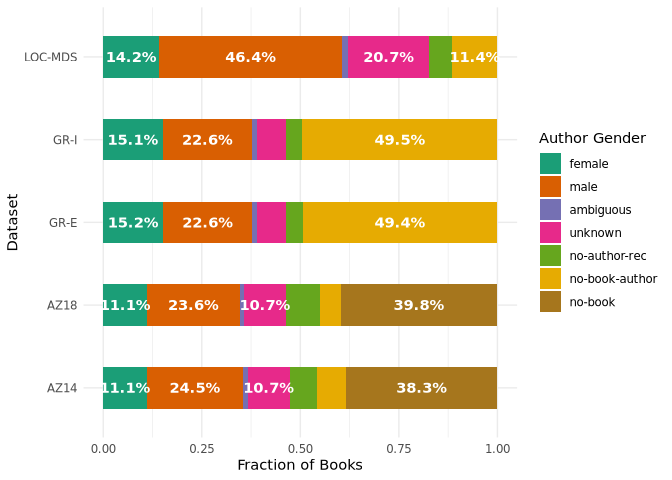

In [ ]:
book_counts %>% fractionalize(all_codes) %>% plot_bars("Books")

In [ ]:
book_counts %>% fractionalize(link_codes, unlink_codes)

# A tibble: 5 × 6
  dataset female  male ambiguous unknown unlinked
  <chr>    <dbl> <dbl>     <dbl>   <dbl>    <dbl>
1 LOC-MDS  0.142 0.464    0.0144  0.207     0.173
2 AZ14     0.111 0.245    0.0110  0.107     0.527
3 AZ18     0.111 0.236    0.0101  0.107     0.536
4 GR-I     0.151 0.226    0.0130  0.0738    0.536
5 GR-E     0.152 0.226    0.0130  0.0736    0.535

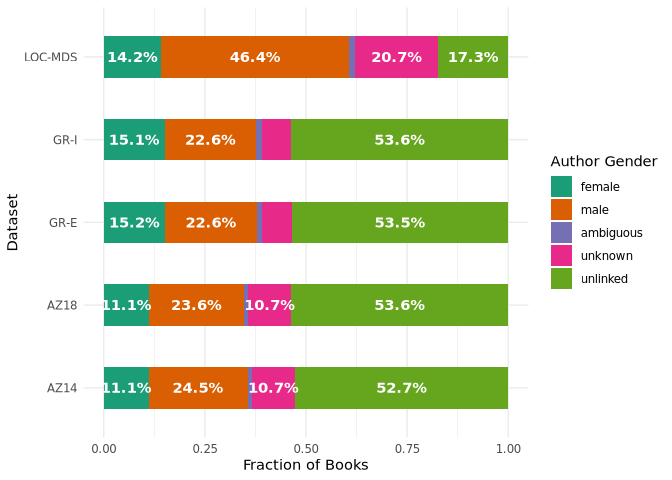

In [ ]:
book_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Books")

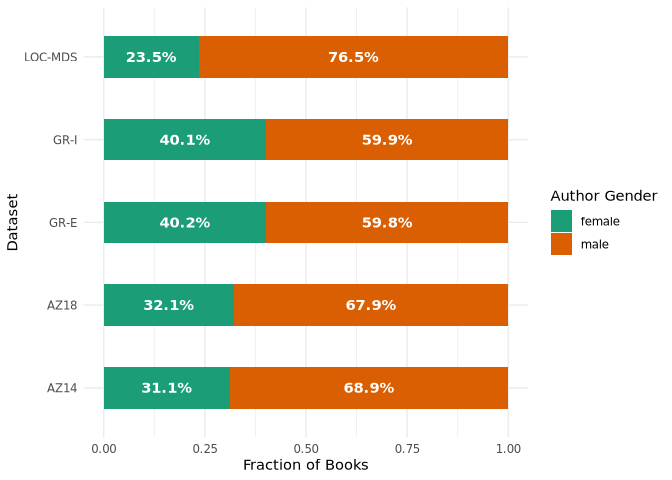

In [ ]:
book_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Books")

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [ ]:
act_counts %>% fractionalize(all_codes)

# A tibble: 4 × 8
  dataset female  male ambiguous unknown `no-author-rec` `no-book-author`
  <chr>    <dbl> <dbl>     <dbl>   <dbl>           <dbl>            <dbl>
1 AZ14     0.220 0.317    0.0414  0.0974          0.0498           0.104 
2 AZ18     0.241 0.307    0.0406  0.0966          0.0661           0.0541
3 GR-I     0.372 0.318    0.110   0.0488          0.0161           0.135 
4 GR-E     0.358 0.334    0.148   0.0374          0.0104           0.112 
# ℹ 1 more variable: `no-book` <dbl>

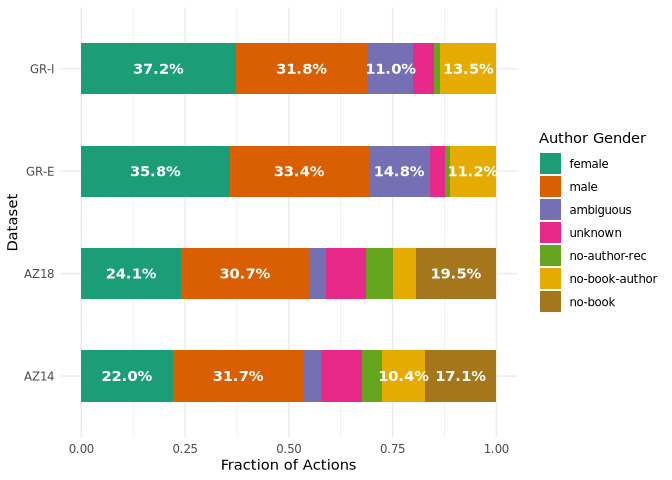

In [ ]:
act_counts %>% fractionalize(all_codes) %>% plot_bars("Actions")

In [ ]:
act_counts %>% fractionalize(link_codes, unlink_codes)

# A tibble: 4 × 6
  dataset female  male ambiguous unknown unlinked
  <chr>    <dbl> <dbl>     <dbl>   <dbl>    <dbl>
1 AZ14     0.220 0.317    0.0414  0.0974    0.325
2 AZ18     0.241 0.307    0.0406  0.0966    0.315
3 GR-I     0.372 0.318    0.110   0.0488    0.151
4 GR-E     0.358 0.334    0.148   0.0374    0.123

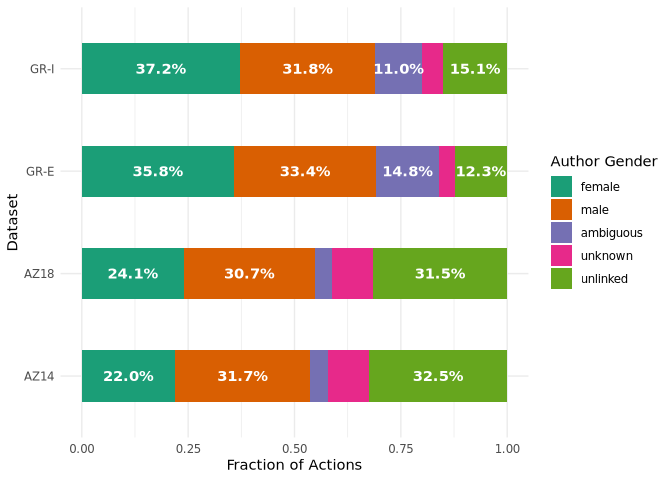

In [ ]:
act_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Actions")

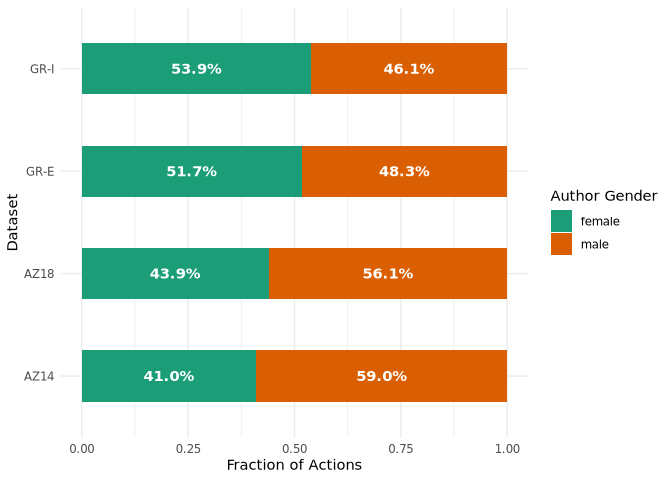

In [ ]:
act_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Actions")

## Metrics

Finally, we’re going to write coverage metrics.

In [ ]:
book_linked = eval(quote(male + female + ambiguous), envir=book_counts)
book_coverage = book_linked / book_counts$total
book_coverage = setNames(book_coverage, book_counts$dataset)
book_coverage

  LOC-MDS      AZ14      AZ18      GR-I      GR-E 
0.6207654 0.3664341 0.3570754 0.3900522 0.3911218 

In [ ]:
json = toJSON(
    as.list(book_coverage),
    auto_unbox=TRUE,
)
write_file(json, "book-coverage.json")